# Install Dependencies

In [2]:
!pip install tensorflow==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow-gpu==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Import Dependencies

In [6]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
import requests
from matplotlib import pyplot as plt

In [7]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [8]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [9]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14002563492213232871
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12534803863472167867
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [10]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [11]:
import tempfile

temp_dir = tempfile.gettempdir() # retrieves the system's temporary directory

temp_dir

'C:\\Users\\utsav\\AppData\\Local\\Temp'

In [12]:
# Setup paths in temp dir
POS_PATH = os.path.join(temp_dir,'data', 'positive')
NEG_PATH = os.path.join(temp_dir,'data', 'negative')
ANC_PATH = os.path.join(temp_dir,'data', 'anchor')
CHEKPOINT_PATH = os.path.join(temp_dir,'data', 'training_checkpoints')
SAVE_MODEL_PATH = os.path.join(temp_dir,'data', 'save_model')
VERIFICATION_IMAGE = os.path.join(temp_dir,'data', 'verification_image')
INPUT_IMAGE = os.path.join(temp_dir,'data', 'input_image')

print("Positive path: ",POS_PATH)
print("Negative path: ",NEG_PATH)
print("Anchor path: ",ANC_PATH)
print("Checkpoint path: ",CHEKPOINT_PATH)
print("Save model path: ",SAVE_MODEL_PATH)
print("Verification image path: ",VERIFICATION_IMAGE)
print("Imput image path: ",INPUT_IMAGE)


Positive path:  C:\Users\utsav\AppData\Local\Temp\data\positive
Negative path:  C:\Users\utsav\AppData\Local\Temp\data\negative
Anchor path:  C:\Users\utsav\AppData\Local\Temp\data\anchor
Checkpoint path:  C:\Users\utsav\AppData\Local\Temp\data\training_checkpoints
Save model path:  C:\Users\utsav\AppData\Local\Temp\data\save_model
Verification image path:  C:\Users\utsav\AppData\Local\Temp\data\verification_image
Imput image path:  C:\Users\utsav\AppData\Local\Temp\data\input_image


In [13]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)
if not os.path.exists(CHEKPOINT_PATH):
    os.makedirs(CHEKPOINT_PATH)
if not os.path.exists(SAVE_MODEL_PATH):
    os.makedirs(SAVE_MODEL_PATH)
if not os.path.exists(VERIFICATION_IMAGE):
    os.makedirs(VERIFICATION_IMAGE)
if not os.path.exists(INPUT_IMAGE):
    os.makedirs(INPUT_IMAGE)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [14]:
from urllib import request

url = "https://figshare.com/ndownloader/files/5976018/lfw.tgz"
target_path = os.path.join(NEG_PATH,"lfw.tgz")

with request.urlopen(request.Request(url), timeout=15.0) as response:
    if response.status == 200:
        with open(target_path, "wb") as f:
            f.write(response.read())

In [15]:
import tarfile

def uncompress_tar(tar_filepath, extract_path):
    try:
        with tarfile.open(tar_filepath, 'r') as tar:
            tar.extractall(path=extract_path)
        print(f"Successfully extracted '{tar_filepath}' to '{extract_path}'")
    except FileNotFoundError:
        print(f"Error: Tar file '{tar_filepath}' not found.")
    except tarfile.ReadError as e:
         print(f"Error: Could not open '{tar_filepath}'. It may be corrupted or not a valid tar file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [16]:
uncompress_tar(target_path,NEG_PATH)

Successfully extracted 'C:\Users\utsav\AppData\Local\Temp\data\negative\lfw.tgz' to 'C:\Users\utsav\AppData\Local\Temp\data\negative'


In [17]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir(os.path.join(NEG_PATH,"lfw")):
    for file in os.listdir(os.path.join(os.path.join(NEG_PATH,"lfw"), directory)):
        EX_PATH = os.path.join(os.path.join(NEG_PATH,"lfw"), directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [18]:
import shutil
# removing the tar and extracted folder from NEG_PATh
os.remove(target_path)
shutil.rmtree(os.path.join(NEG_PATH,"lfw"))

#### Positive collection from webcam

In [19]:
# importing uuid library to geenrate unique image names
import uuid

In [26]:
#url = 'http://192.168.100.35:8080/video'

In [87]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 30

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

#### Anchor collection from webcam

In [30]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 30

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Data Augmentation

In [88]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [21]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

KeyboardInterrupt: 

In [89]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

#### Get images directories

In [115]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [116]:
dir_test = anchor.as_numpy_iterator()

In [117]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\528df416-3a9c-11f0-8da9-c423607b4a5c.jpg'


#### Preprocessing - Scale and Resize

In [118]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [119]:
img = preprocess(dir_test.next())

In [120]:
img.numpy()

array([[[0.35980392, 0.40294117, 0.3480392 ],
        [0.37034315, 0.3997549 , 0.34779412],
        [0.38602942, 0.39779413, 0.34583333],
        ...,
        [0.40539217, 0.40539217, 0.35833332],
        [0.4110294 , 0.4110294 , 0.36397058],
        [0.4137255 , 0.41764706, 0.3627451 ]],

       [[0.35490197, 0.38627452, 0.33333334],
        [0.3620098 , 0.38946077, 0.33235294],
        [0.37843138, 0.3882353 , 0.3362745 ],
        ...,
        [0.40539217, 0.40539217, 0.3602941 ],
        [0.40098038, 0.40098038, 0.35588235],
        [0.4019608 , 0.4019608 , 0.35686275]],

       [[0.35171568, 0.37720588, 0.32132354],
        [0.36421567, 0.38137254, 0.32647058],
        [0.3740196 , 0.3882353 , 0.33406863],
        ...,
        [0.40098038, 0.39215687, 0.35588235],
        [0.40857843, 0.3997549 , 0.3634804 ],
        [0.39313725, 0.39313725, 0.35392156]],

       ...,

       [[0.31593138, 0.35906863, 0.29632354],
        [0.32058823, 0.36372548, 0.30294117],
        [0.32058823, 0

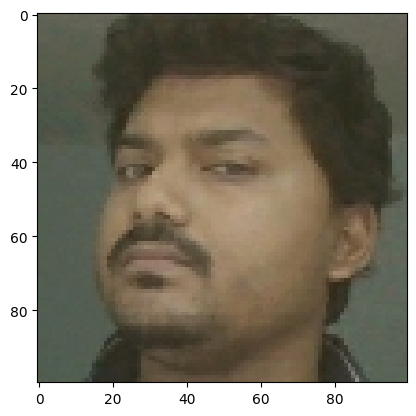

In [121]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [122]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [123]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [124]:
samples = data.as_numpy_iterator()

In [125]:
example = samples.next()

In [126]:
example

(b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\37826f99-3a9c-11f0-87c4-c423607b4a5c.jpg',
 b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\positive\\6d94340d-3aa1-11f0-bd0e-c423607b4a5c.jpg',
 1.0)

#### Build Train and Test Partition

In [127]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [128]:
res = preprocess_twin(*example)

In [129]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.40098038, 0.40490195, 0.35      ],
         [0.4017157 , 0.40563726, 0.3507353 ],
         [0.39534312, 0.3992647 , 0.34436274],
         ...,
         [0.40612745, 0.41985294, 0.3620098 ],
         [0.4151961 , 0.42303923, 0.36813724],
         [0.41960785, 0.42745098, 0.37254903]],
 
        [[0.4       , 0.4       , 0.3529412 ],
         [0.3970588 , 0.3970588 , 0.35196078],
         [0.39044118, 0.39044118, 0.34534314],
         ...,
         [0.41568628, 0.42794117, 0.37083334],
         [0.40882352, 0.41666666, 0.3617647 ],
         [0.40294117, 0.40980393, 0.35490197]],
 
        [[0.38137254, 0.38137254, 0.34019607],
         [0.38210785, 0.38210785, 0.34289217],
         [0.3872549 , 0.3872549 , 0.3480392 ],
         ...,
         [0.4120098 , 0.41985294, 0.36495098],
         [0.41421568, 0.42205882, 0.36715686],
         [0.41568628, 0.41960785, 0.3647059 ]],
 
        ...,
 
        [[0.3375    , 0.3884804 

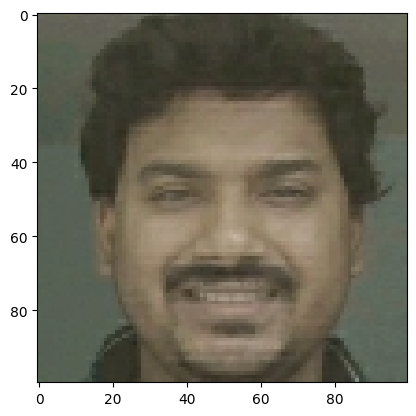

In [130]:
plt.imshow(res[0])

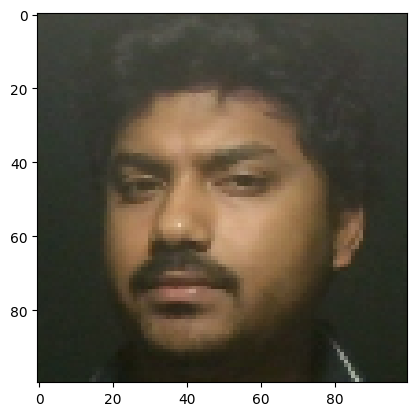

In [131]:
plt.imshow(res[1])

In [132]:
preprocess_twin

<function __main__.preprocess_twin(input_img, validation_img, label)>

In [133]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [134]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [135]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [136]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [137]:
len(test_data)

12

# Model Engineering

#### Build Embedding Layer

In [138]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [139]:
embedding = make_embedding()

In [140]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

#### Build Distance Layer

In [142]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

#### Make Siamese Model

In [143]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [144]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

#### Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### Establish Checkpoints

In [53]:
checkpoint_dir = CHEKPOINT_PATH
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### Build Train Step Function

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
X = batch_1[:2]

In [57]:
X

(array([[[[0.44705883, 0.5019608 , 0.4117647 ],
          [0.4370098 , 0.49191177, 0.39289215],
          [0.45539215, 0.50735295, 0.40539217],
          ...,
          [0.45906863, 0.48259804, 0.38063726],
          [0.45882353, 0.48235294, 0.38039216],
          [0.45882353, 0.48235294, 0.38039216]],
 
         [[0.44485295, 0.49779412, 0.40857843],
          [0.4502451 , 0.5019608 , 0.40392157],
          [0.45392156, 0.5019608 , 0.40098038],
          ...,
          [0.4615196 , 0.485049  , 0.38308823],
          [0.46078432, 0.48431373, 0.38235295],
          [0.4617647 , 0.4852941 , 0.38333333]],
 
         [[0.44730392, 0.4862745 , 0.39509803],
          [0.45857844, 0.49191177, 0.4004902 ],
          [0.45857844, 0.49191177, 0.39754903],
          ...,
          [0.45196077, 0.48137254, 0.3852941 ],
          [0.45563725, 0.47843137, 0.38455883],
          [0.45490196, 0.47549018, 0.38235295]],
 
         ...,
 
         [[0.42745098, 0.48235294, 0.39215687],
          [0.42573

In [58]:
y = batch_1[2]

In [59]:
y

array([0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [60]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

#### Build Training Loop

In [61]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [62]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

#### Train the model

In [63]:
EPOCHS = 50

In [64]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 25s 546ms/step
0.5129467 0.19138756 1.0

 Epoch 2/50
27/27 [==============================] - 14s 503ms/step
0.26763713 0.9047619 1.0

 Epoch 3/50
27/27 [==============================] - 14s 500ms/step
0.10106562 0.9768519 0.995283

 Epoch 4/50
27/27 [==============================] - 14s 505ms/step
0.0019144928 0.98564595 1.0

 Epoch 5/50
27/27 [==============================] - 14s 500ms/step
0.01937503 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 13s 498ms/step
0.04032831 0.99523807 0.99523807

 Epoch 7/50
27/27 [==============================] - 13s 488ms/step
0.50006485 0.9809524 1.0

 Epoch 8/50
27/27 [==============================] - 13s 490ms/step
0.12691723 0.97183096 1.0

 Epoch 9/50
27/27 [==============================] - 13s 488ms/step
0.0118194055 0

KeyboardInterrupt: 

# Evaluate Model

#### Import Metrics


In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

#### Make Predictions

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
len(test_input)

16

In [ ]:
y_true

array([0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 25ms/step


In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]

In [ ]:
y_true

array([0., 0., 1., 0.], dtype=float32)

#### Calculate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 28ms/step
1.0 0.9886364


#### Visual Results

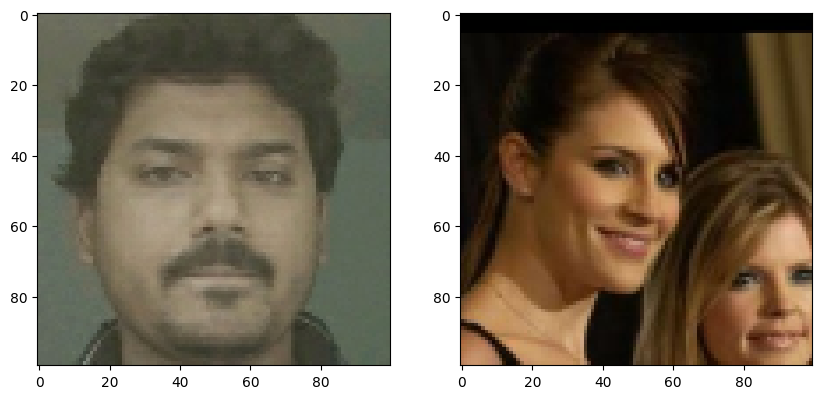

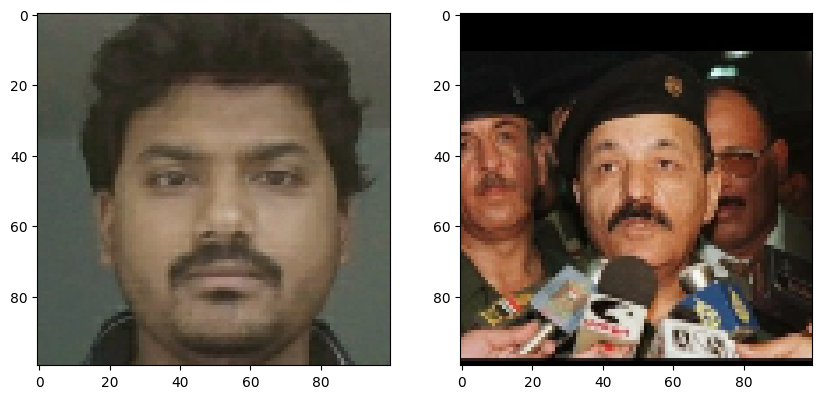

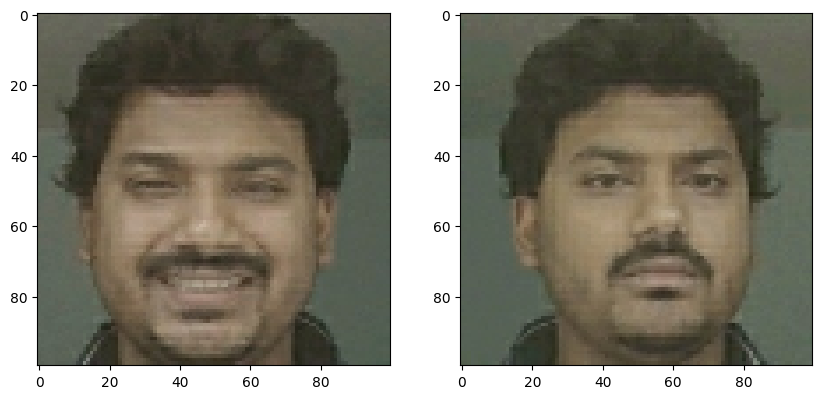

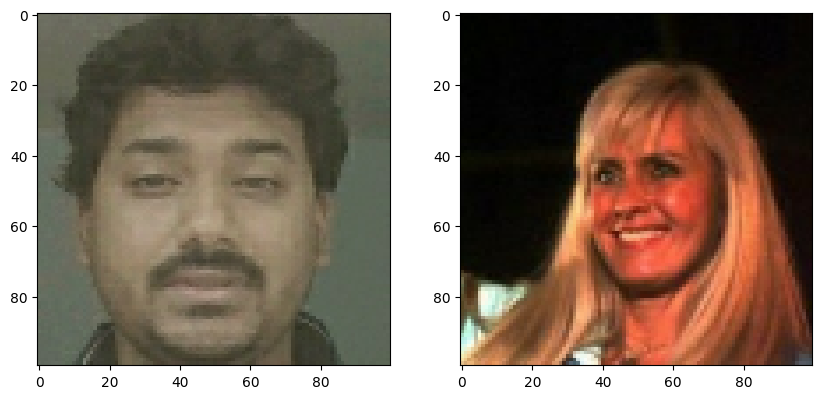

In [ ]:

for i in range(len(test_input)):

    # Set plot size 
    plt.figure(figsize=(10,8))

    # Set first subplot
    plt.subplot(1,2,1)
    plt.imshow(test_input[i])

    # Set second subplot
    plt.subplot(1,2,2)
    plt.imshow(test_val[i])

    # Renders cleanly
    plt.show()

#### Save Model

In [ ]:
siamese_model.save(os.path.join(SAVE_MODEL_PATH,'siamesemodelv2.h5'))

In [65]:
# Reload model 
siamese_model = tf.keras.models.load_model(os.path.join(SAVE_MODEL_PATH,'siamesemodelv2.h5'), custom_objects={'L1Dist':L1Dist})

In [66]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

NameError: name 'test_input' is not defined

In [67]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"


__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][0]']         
          

# Real Time Test

#### Load random positive image in verification folder

In [90]:
def copy_random_files(source_dir, dest_dir, num_files=50):

    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' does not exist.")
        return

    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    if len(files) < num_files:
        print(f"Warning: Only {len(files)} files available, copying all.")
        num_files = len(files)

    random_files = random.sample(files, num_files)

    for file in random_files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.copy2(source_path, dest_path)
        print(f"Copied: {file}")

In [91]:
copy_random_files(POS_PATH, VERIFICATION_IMAGE)

Copied: a489940e-3aa1-11f0-b90f-c423607b4a5c.jpg
Copied: 9e90771e-3aa1-11f0-8630-c423607b4a5c.jpg
Copied: 7324f1a2-3aa1-11f0-8fb8-c423607b4a5c.jpg
Copied: 96d2338d-3aa1-11f0-b029-c423607b4a5c.jpg
Copied: 84fe92a2-3aa1-11f0-bad6-c423607b4a5c.jpg
Copied: 9080e4c3-3aa1-11f0-b331-c423607b4a5c.jpg
Copied: 8a4b1396-3aa1-11f0-8ac4-c423607b4a5c.jpg
Copied: 8da43085-3aa1-11f0-9e4b-c423607b4a5c.jpg
Copied: 91c8033d-3aa1-11f0-9345-c423607b4a5c.jpg
Copied: 945d1da5-3aa1-11f0-9cc3-c423607b4a5c.jpg
Copied: 74a2033a-3aa1-11f0-b7e2-c423607b4a5c.jpg
Copied: b246e498-3aa1-11f0-9759-c423607b4a5c.jpg
Copied: a5dc7dd9-3aa1-11f0-a1e9-c423607b4a5c.jpg
Copied: 700228f7-3aa1-11f0-b549-c423607b4a5c.jpg
Copied: 87a0b3b9-3aa1-11f0-96a8-c423607b4a5c.jpg
Copied: 654d8b31-3aa1-11f0-9adf-c423607b4a5c.jpg
Copied: 744d7355-3aa1-11f0-ae37-c423607b4a5c.jpg
Copied: a0b6f47f-3aa1-11f0-a318-c423607b4a5c.jpg
Copied: 85c568a3-3aa1-11f0-8482-c423607b4a5c.jpg
Copied: a36db7d3-3aa1-11f0-9c2c-c423607b4a5c.jpg
Copied: b27853c3-3aa

#### Verification Function

In [73]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(VERIFICATION_IMAGE):
        input_img = preprocess(os.path.join(INPUT_IMAGE, 'input_image.jpg'))
        validation_img = preprocess(os.path.join(VERIFICATION_IMAGE, image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(VERIFICATION_IMAGE))
    verified = verification > verification_threshold
    
    return results, verified

#### OpenCV Real Time Verification

In [114]:
cap = cv2.VideoCapture(0)  # 0 is usually the default camera

ret, frame = cap.read()

frame = frame[120:120+250,200:200+250, :]

cv2.imshow('Verification', frame)

cv2.waitKey(500)

if ret:
    cv2.imwrite(os.path.join(INPUT_IMAGE, 'input_image.jpg'), frame)


cap.release()  # Release the camera
cv2.destroyAllWindows()
        
results, verified = verify(siamese_model, 0.9, 0.7)
print(verified)

1/1 [==============================] - 0s 21ms/step
True


In [105]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join(INPUT_IMAGE, 'input_image.jpg'), frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [147]:
results, verified = verify(siamese_model, 0.9, 0.7)
print(verified)

1/1 [==============================] - 0s 19ms/step
False
